In [159]:
import pandas as pd
import numpy as np
import requests
import time
import math
import re
import pickle
import itertools
import glob
import string

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

from textblob import TextBlob

import gensim 
import gensim.downloader as gensim_api
from gensim.models.phrases import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

In [17]:
sns.set_style('darkgrid')
sns.set_palette("winter_r")

## Data
* Top Large Companies 
* Low Rated Large Companies 
* Lowly rated companies 

### Analysis
* What are the top companies doing really well? 
* From an employee standpoint, why are these the top companies? What matters to employees the most? 
* What are the companies performing poorly doing wrong? From an employee standpoint, why are these companies failing? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Topic Modeling 

### Prediction
* predict a review rating based on the incidence of certain words (ie: if you include great people, more likely to be a 5) 
    * feature engineering? bool for 'great people' or not? 

* Feature engineering: Sentiment analysis on headline - ie: pos, neut, neg headline - is this a predictor for rating as well? 

* Can we predict the rating based on text? Can be used for surveys and other text based feedback. 
* Has the sentiment at top companies stayed the same over time? 
* Classification

* Rating a company as 'desirable' or 'not desirable'
* Desirable company: 4-5 stars avg since 2019
* Not desirable: < 4 stars avg since 2019 

## Load Files 

In [80]:
"""
Takes in a list of csv files using glob 
Output: dataframe combining all csvs vertically (axis=0)
Assumes all csvs have same column names 
"""
def files_to_df(glob_csv):
    final_df = pd.DataFrame()
    
    for file in glob_csv:
        company_name = file.split('\\')[1].split('.')[0] # get the company name from the file 
        try:
            df = pd.read_csv(file)
        except:
            df = pd.read_csv(file, encoding='latin1')
        
        # drop the extra index column 
        df = df.drop(df.columns[0], axis=1)
        
        #check if there's a company column, if not, add company name to all rows  
        if pd.isnull(df.iloc[0].company):
            df.company = company_name
        
        final_df = pd.concat([final_df, df])
        
    return final_df

In [81]:
""" 
Load all csv files from folders 
drop each group into a dataframe 

"""
csvfiles = glob.glob('reviews/investment/' + '*.csv')
investment_reviews =  files_to_df(csvfiles)

In [85]:
print(investment_reviews.isna().sum())
print(len(investment_reviews))

company               0
headline             30
date                  0
overall_rating        0
author_position    1146
pros                  0
cons                  0
dtype: int64
11330


## Analyzing Investment Management Industry Firms 

* Who are the top firms? 
* Are there similarities between these companies and the GD top companies? 
* For the companies that are not doing well, what are the reasons? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Which companies are on an upward trend? 
* Can we predict the rating based on the review? 

In [ ]:
def position_level(position):
    executive_pattern = re.compile("[Cc]\w[Oo]")
    sr_manager_pattern = re.compile("(senior)\s(\w*)\s(manager)")
    if executive_pattern.match(position.lower()) or sr_manager_pattern.match(position.lower()):
        return "senior"
    
    senior = ["director", "chief", "executive", "senior manager", "head", "general manager", "leader", "president", "vp"]
    for pos in senior:
        if pos in position.lower():
            return "senior"
    
    return "other"


def position_department(position):
    try: 
        marketing_sales = ["marketing", "market", "sales", "seo", "ppc", "sdr", "bdr", "account", "demand", "lead gen", "business development", "csm", "customer", "success", "content", "creative", "client"]
        for pos in marketing_sales:
            if pos in position.lower():
                return "marketing_sales"

        hr = ["human", "hr", "recruit", "talent", "l&d", "learning", "people", "culture", "diversity", "inclusion"]
        for pos in hr:
            if pos in position.lower():
                return "hr"

        finance = ["accounting", "valuation", "controller", "accountant", "finance", "payable", "receivable", "financial", "financial analyst", "fp"]
        for pos in finance:
            if pos in position.lower():
                return "finance"

        tech = ["engineer", "data", "software", "ux", "ui", "experience", "developer", "product", "tech", "programmer", "it ", "information", "solution"]
        for pos in tech:
            if pos in position.lower():
                return "technology"
        
        investment = ["investment", "risk", "quantitative", "quant", "analyst", "trading", "trader", "investor", "front office", "portfolio"]
        for pos in investment:
            if pos in position.lower():
                return "investment"
            
    except:
        print(position)
    
    return "other"

def fill_missing_values(df):
    position_missing = df.author_position.isna().sum()
    headline_missing = df.headline.isna().sum()
    
#     print(f"There are {position_missing} missing position records.")
#     print(f"There are {headline_missing} missing headline records.")
    
    df.author_position = df.author_position.fillna("unknown")
    df.headline = df.headline.fillna('')
    df.pros = df.pros.fillna('')
    print('After filling missing values: ')
    print(df.isna().sum())

    return df 

def create_position_cols(df):
    df['position_department'] = df.author_position.apply(lambda x: position_department(x))
    df['position_level'] = df.author_position.apply(lambda x: position_level(x))
    return df 

def convert_datetime(df):
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    return df


In [87]:
# Cleaning and new columns 
reviews = reviews[reviews.date > '2011-12-31'] 
reviews = convert_datetime(investment_reviews)
reviews = fill_missing_values(reviews)
reviews = create_position_cols(reviews)
reviews = reviews[reviews.pros.apply(lambda x: not pd.isnull(x))]

After filling missing values: 
company            0
headline           0
date               0
overall_rating     0
author_position    0
pros               0
cons               0
dtype: int64


In [ ]:
recent_reviews = reviews[reviews.date > '2020-03-01'] 
print(len(reviews))
print(len(recent_reviews))

In [93]:
# Add mean rating column 
reviews_by_rating = recent_reviews.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'})
rating_dict = reviews_by_rating.set_index('company').to_dict()['mean_rating']
recent_reviews['mean_rating'] = recent_reviews.company.apply(lambda x: float(rating_dict[x]))

# Add reviews count column 
reviews_count = recent_reviews.groupby('company').headline.count().reset_index().rename(columns={'headline':'count'})
count_dict = reviews_count.set_index('company').to_dict()['count']
recent_reviews['review_count'] = recent_reviews.company.apply(lambda x: int(count_dict[x]))

recent_reviews

,company,headline,date,overall_rating,author_position,pros,cons,position_department,position_level,mean_rating
0,Allianz Global Investors,Great People,2022-04-21,5.0,Human Resources Business Partner,"People, benefits, management, team and culture.",I have no cons to share,hr,other,3.628571
1,Allianz Global Investors,Great company,2022-04-11,5.0,Working Student,"Good culture, interesting company, great colle...",not encountered any so far,other,other,3.628571
2,Allianz Global Investors,Working Student,2022-04-07,5.0,Working Student,"Good company, nice colleagues, good perks","Nothing at the moment, everything is fine",other,other,3.628571
3,Allianz Global Investors,Good employer,2022-04-05,5.0,IT Project Manager,Flexible working \r\nNice colleagues\r\nNew te...,the management is not always aligned to the cu...,technology,other,3.628571
4,Allianz Global Investors,Mostly positive experience,2022-03-31,4.0,Analyst,Staff are generally approachable and collabora...,Internal decision making can be overly politic...,investment,other,3.628571
...,...,...,...,...,...,...,...,...,...,...
54,Two Sigma,Decent,2020-07-01,4.0,Technical Recruiter,Solid professional development and collaboration,Long hours and little work life balance,hr,other,4.271186
55,Two Sigma,"Great benefits, smart people but lacks culture...",2020-06-08,4.0,Current Employee,Employees are treated extremely well. Health i...,Lack of culture (which is common for a large c...,other,other,4.271186
56,Two Sigma,Great place to work,2020-06-05,4.0,Senior Vice President,- More Silicon Valley than Wall Street\r\n- Ve...,- Need to do a better job at leadership develo...,other,senior,4.271186
57,Two Sigma,Overall a great place to be,2020-04-03,5.0,Software Engineer(),Good wlb\r\nPeople are friendly\r\nCompensatio...,Growing pains lead to bad software stack in ma...,finance,other,4.271186


# Text Preprocessing

* Using Regex & NLTK libraries
* Noise Removal – Removing unnecessary characters and formatting
* Tokenization – break multi-word strings into smaller components
* Normalization – a catch-all term for processing data; this includes stemming and lemmatization
    * Upper or lowercasing
    * Stopword removal
    * Stemming – bluntly removing prefixes and suffixes from a word
    * Lemmatization – replacing a single-word token with its root

## Define Methods

In [95]:
# TODO pycontractions 
# TODO find a better way to remove companies ie: BX, blackstone, blackstone group

# https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

def preprocess_text(text, company_list):
    
    # remove html, hyphens, numbers 
    r_unwanted = re.compile("(\\.)|(\s-)|(^-)|(\d)")

    # make all words lowercase, and sub in regex  
    text = r_unwanted.sub(' ',text.lower())
    
    # remove mentions of company 
    for company in company_list:
        text = text.replace(company, "")
    
    # remove spelling mistakes 
    text = str(TextBlob(text).correct())
        
    # remove quotes 
    quotes_unwanted = re.compile("\s[\'\"]|[\'\"]\s")
    text = quotes_unwanted.sub(' ', text)  
    
    # create a stopwords list including numbers and punctuation
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['there\'s',"'s", 'n\'t', '\'ve','\'m']
    
    # tokenize words 
    text_lst = [word for word in word_tokenize(text) if word not in stopwords_list]
#     print(text_lst)
        
    # lemmatize words 
    lemmatizer = WordNetLemmatizer()
    lemmatized_lst = [lemmatizer.lemmatize(word) for word in text_lst]
           
    # combine into one string from list                                      
    final_lst = " ".join(lemmatized_lst)
    return final_lst



def get_company_list(df):
    final_lst = []
    for company in df.company.unique():
        final_lst.append(company.lower())
    return final_lst



In [96]:
# company_list = get_company_list(top_recent_reviews)
# test_review = "I'm proud to work at Atlassian because"
# preprocess_text(test_review, company_list)

In [99]:
with open('investment_company_reviews_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [97]:
company_list = get_company_list(reviews)
df = reviews
df['pros_cleaned'] = df['pros'].apply(lambda x: preprocess_text(x, company_list))
df['cons_cleaned'] = df['cons'].apply(lambda x: preprocess_text(x, company_list))
df['headline_cleaned'] = df['headline'].apply(lambda x: preprocess_text(x, company_list))
df['combined_text'] = df['pros_cleaned'] + " " + df['cons_cleaned'] + " " + df['headline_cleaned']
df.head()

,company,headline,date,overall_rating,author_position,pros,cons,position_department,position_level,pros_cleaned,cons_cleaned,headline_cleaned
0,Allianz Global Investors,Great People,2022-04-21,5.0,Human Resources Business Partner,"People, benefits, management, team and culture.",I have no cons to share,hr,other,people benefit management team culture,son share,great people
1,Allianz Global Investors,Great company,2022-04-11,5.0,Working Student,"Good culture, interesting company, great colle...",not encountered any so far,other,other,good culture interesting company great colleague,encountered far,great company
2,Allianz Global Investors,Working Student,2022-04-07,5.0,Working Student,"Good company, nice colleagues, good perks","Nothing at the moment, everything is fine",other,other,good company nice colleague good peak,nothing moment everything fine,working student
3,Allianz Global Investors,Good employer,2022-04-05,5.0,IT Project Manager,Flexible working \r\nNice colleagues\r\nNew te...,the management is not always aligned to the cu...,technology,other,flexible working nice colleague new technology...,management always signed current technology,good employer
4,Allianz Global Investors,Mostly positive experience,2022-03-31,4.0,Analyst,Staff are generally approachable and collabora...,Internal decision making can be overly politic...,investment,other,staff generally unapproachable collaboration n...,internal decision making overlay political thu...,mostly positive experience


In [143]:
df['combined_text'] = df['pros_cleaned'] + " " + df['cons_cleaned'] + " " + df['headline_cleaned']

In [98]:
with open('investment_company_reviews_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [100]:
len(df)

11330

## EDA

## Define Methods

In [102]:
"""
visualize distribution of reviews by year.
input requires a 'date' and a headline column in datetime format
plots barplot 
"""

def reviews_by_year(df, display=True):
    temp_df = df.copy()
    temp_df['year'] = temp_df.date.apply(lambda x: x.year)
    count_year = temp_df.groupby('year').headline.count().reset_index()
    count_year['count_normalized'] = round(((count_year['headline'] / count_year['headline'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_year.year, y=count_year.headline)
    plt.show()
    if display:
        print(count_year[['year','count_normalized']])

## General Data Exploration

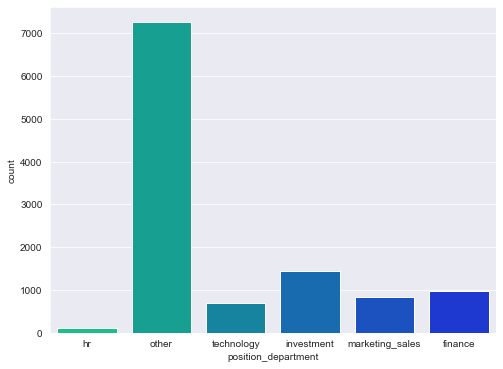

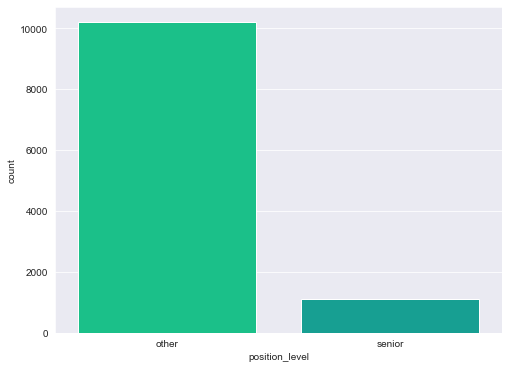

In [104]:
# how many reviews for each type of position 
plt.figure(figsize=(8,6))
sns.countplot(df.position_department)
plt.show()

# how many reviews for each level of position 
plt.figure(figsize=(8,6))
sns.countplot(df.position_level)
plt.show()

In [105]:
df.groupby('position_department').overall_rating.mean().reset_index()

,position_department,overall_rating
0,finance,3.759585
1,hr,4.032787
2,investment,3.835862
3,marketing_sales,3.529412
4,other,3.511093
5,technology,3.627312


In [106]:
df.groupby('position_level').overall_rating.mean().reset_index()

,position_level,overall_rating
0,other,3.584109
1,senior,3.623330


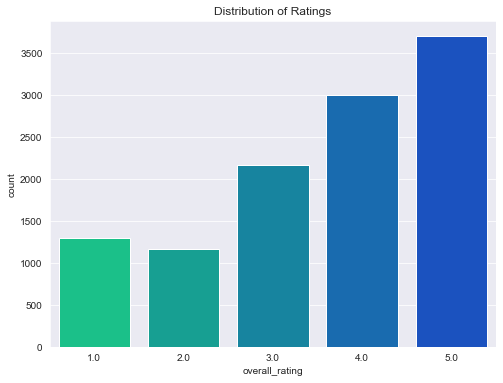

In [107]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Ratings')
sns.countplot(df['overall_rating'])
plt.show()

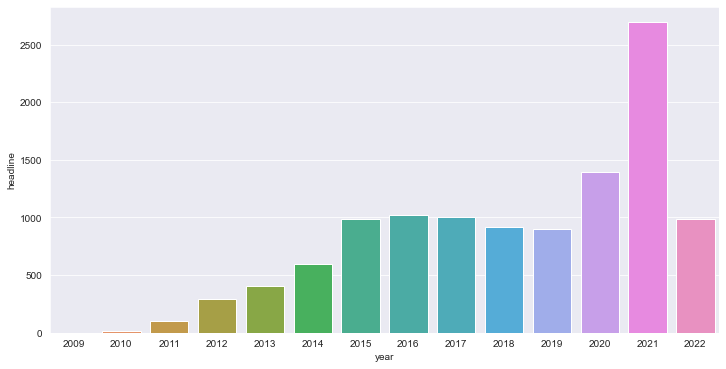

    year  count_normalized
0   2009              0.02
1   2010              0.16
2   2011              0.88
3   2012              2.61
4   2013              3.56
5   2014              5.27
6   2015              8.68
7   2016              9.05
8   2017              8.89
9   2018              8.08
10  2019              7.97
11  2020             12.31
12  2021             23.78
13  2022              8.75


In [108]:
reviews_by_year(df)

In [ ]:
# TODO Ratings over time 
# month and year since 2012 

## Words Analysis

In [126]:
def get_corpus_lst(corpus):
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_grams)
    return lst_corpus

In [144]:
corpus = df['combined_text']
# corpus = pd.concat([df.pros_cleaned, df.headline_cleaned], axis=0)
lst_corpus = get_corpus_lst(corpus)

In [145]:
tokens = list(itertools.chain(*lst_corpus))
freqdist = FreqDist(tokens)
most_common = freqdist.most_common(50)
most_common

[('work', 8245),
 ('great', 7156),
 ('good', 6188),
 ('people', 5521),
 ('company', 4918),
 ('culture', 3506),
 ('management', 3171),
 ('place', 3036),
 ('benefit', 2701),
 ('employee', 2537),
 ('lot', 2336),
 ('environment', 2221),
 ('pay', 2013),
 ('opportunity', 1942),
 ('hour', 1884),
 ('time', 1867),
 ('get', 1733),
 ('firm', 1722),
 ('working', 1655),
 ('balance', 1593),
 ('team', 1540),
 ('office', 1521),
 ('long', 1437),
 ('manager', 1397),
 ('job', 1397),
 ('experience', 1268),
 ('smart', 1268),
 ('nice', 1207),
 ('life', 1207),
 ('many', 1200),
 ('like', 1196),
 ('career', 1158),
 ('really', 1137),
 ('growth', 1098),
 ('year', 1092),
 ('’', 1072),
 ('much', 1037),
 ('make', 1030),
 ('high', 1008),
 ('one', 959),
 ('business', 925),
 ('hard', 912),
 ('best', 908),
 ('senior', 901),
 ('compensation', 898),
 ('salary', 885),
 ('new', 883),
 ('learn', 870),
 ('day', 864),
 ('well', 855)]

In [137]:
# TODO visualize most common words 

In [111]:
total_word_count = len(tokens)
print(f'There are {total_word_count} words in the vocabulary of corpus, after stopwords have been removed.\n')
print('Normalized Frequency\n')
for word in most_common:
    normalized_freq = word[1] / total_word_count
    print(f'{word[0]}: {normalized_freq}')

There are 157326 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

great: 0.04242782502574272
good: 0.035035531317137665
work: 0.03445711452652454
people: 0.02401383115314697
company: 0.020416205840102716
place: 0.01538842912169635
benefit: 0.015299441923140485
culture: 0.014689243990185983
environment: 0.00992842886744721
opportunity: 0.00893050099792787
lot: 0.00854277106136303
pay: 0.007856298386789215
employee: 0.007716461360487141
smart: 0.007500349592565755
nice: 0.0071444007983422955
management: 0.0069092203450160814
experience: 0.0059748547601795
firm: 0.005949429846306396
working: 0.00582866150540915
balance: 0.005726961849916733
team: 0.005332875684883618
office: 0.005307450771010513
learn: 0.004665471695714631
best: 0.00436037272923738
get: 0.004156973418252546
life: 0.004093411133569785
job: 0.003978999021140816
career: 0.003896368051053227
compensation: 0.0038200933094339144
really: 0.003813737080965638
time: 0.003807380852497362


In [146]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.BigramCollocationFinder.from_words(tokens)
bigrams_scored = finder.score_ngrams(bigram_measures.raw_freq)
bigrams_scored[:10]

[(('place', 'work'), 0.004388238895100789),
 (('great', 'place'), 0.0033388095223222374),
 (('work', 'life'), 0.002717272483087321),
 (('life', 'balance'), 0.00267042295751685),
 (('great', 'company'), 0.0024674083467114754),
 (('long', 'hour'), 0.0022425306239732146),
 (('smart', 'people'), 0.0021082286506711977),
 (('great', 'benefit'), 0.0017053227307651465),
 (('work', 'environment'), 0.001689706222241656),
 (('great', 'people'), 0.0016491033000805811)]

In [147]:
pmi_finder = nltk.BigramCollocationFinder.from_words(tokens)
pmi_finder.apply_freq_filter(5)
pmi_scored = finder.score_ngrams(bigram_measures.pmi)
pmi_scored[:10]

[(('+pay', '+hours'), 18.288496631778678),
 (('-unless', 'howe'), 18.288496631778678),
 (('accumulation', 'ridden'), 18.288496631778678),
 (('acknowledging', 'hiccup'), 18.288496631778678),
 (('acupuncture', 'chiropractor'), 18.288496631778678),
 (('addressed-', 'updated/more'), 18.288496631778678),
 (('aggravation', 'affront'), 18.288496631778678),
 (('all-white', 'brightly'), 18.288496631778678),
 (('amazon/ff', 'size/level'), 18.288496631778678),
 (('amid', 'cultist'), 18.288496631778678)]

In [130]:
"""
min_count (float, optional) – 
Ignore all words and bigrams with total collected count lower than this value.

threshold (float, optional) – 
Represent a score threshold for forming the phrases (higher means fewer phrases). 
A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. 
Heavily depends on concrete scoring-function, see the scoring parameter.
"""
bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=5)
bigrams_phraser = gensim.models.phrases.Phraser(bigrams_detector)
# lst_bigrams = list(bigrams_detector[tokens])
# for phrase in bigrams_detector[tokens]:
#     print(phrase)

In [148]:
lst_corpus_bigrams = list(bigrams_phraser[lst_corpus])

In [149]:
len(lst_corpus_bigrams)

11330

In [134]:
lst_corpus

[['people', 'benefit', 'management', 'team', 'culture'],
 ['good', 'culture', 'interesting', 'company', 'great', 'colleague'],
 ['good', 'company', 'nice', 'colleague', 'good', 'peak'],
 ['flexible', 'working', 'nice', 'colleague', 'new', 'technology', 'work'],
 ['staff',
  'generally',
  'unapproachable',
  'collaboration',
  'nice',
  'working',
  'environment'],
 ['clear',
  'corporate',
  'strategy',
  'good',
  'performing',
  'product',
  'meaningful',
  'connection'],
 ['nice', 'benefit', 'good', 'employee'],
 ['benefit', 'discretionary', 'bonus', 'bad'],
 ['people', 'friendly', 'manager', 'understanding'],
 ['friendly', 'atmosphere', 'people', 'great', 'benefit'],
 ['great',
  'work',
  'life',
  'balance',
  'excellent',
  'respectful',
  'culture',
  'good',
  'colleague'],
 ['nice', 'people', 'work'],
 ['small', 'international', 'team', 'everyone', 'pleasant', 'work'],
 ['wonderful', 'wonderful', 'wonderful', 'good', 'good'],
 ['fantastic', 'people', 'thoughtful', 'considera

## LDA Topic Modeling 
* Pros: what are the latent topics within the pros column at top companies? 

In [152]:
# every unique term assigned an index
id2word = Dictionary(lst_corpus_bigrams)

# convert into doc term matrix
doc_term_matrix = [id2word.doc2bow(r) for r in lst_corpus_bigrams]
doc_term_matrix[:1]
# word id 0 occurs once in the first document 

In [154]:
LDA = gensim.models.ldamodel.LdaModel
#corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=123, 
lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=10, random_state=123, passes=25)

In [155]:
lda_model.print_topics()

[(0,
  '0.019*"’" + 0.014*"employee" + 0.011*"management" + 0.009*"firm" + 0.008*"company" + 0.007*"team" + 0.006*"one" + 0.006*"leadership" + 0.006*"many" + 0.005*"new"'),
 (1,
  '0.014*"lot" + 0.011*"time" + 0.010*"people" + 0.009*"get" + 0.009*"opportunity" + 0.008*"work" + 0.008*"project" + 0.008*"employee" + 0.007*"make" + 0.007*"culture"'),
 (2,
  '0.020*"people" + 0.018*"good" + 0.016*"really" + 0.015*"work" + 0.014*"get" + 0.012*"day" + 0.011*"place" + 0.011*"job" + 0.010*"working" + 0.010*"like"'),
 (3,
  '0.060*"great" + 0.053*"work" + 0.045*"company" + 0.031*"people" + 0.024*"culture" + 0.015*"environment" + 0.014*"great place" + 0.012*"benefit" + 0.010*"amazing" + 0.009*"really"'),
 (4,
  '0.050*"great" + 0.044*"good" + 0.031*"balance" + 0.028*"work" + 0.028*"work life" + 0.023*"culture" + 0.016*"analyst" + 0.013*"hour" + 0.013*"company" + 0.013*"long hour"'),
 (5,
  '0.114*"good" + 0.037*"benefit" + 0.032*"work" + 0.030*"great" + 0.028*"company" + 0.028*"pay" + 0.025*"peop

In [158]:
get_coherence_scores(lda_model, lst_corpus_bigrams, doc_term_matrix, id2word)

(0.4428790294730707, -7.814963969649387)

In [157]:
def get_coherence_scores(lda_model, texts, doc_term_matrix, dictionary, display=False):
    # get the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    # get perplexity, lower the better 
    perplexity_score = lda_model.log_perplexity(doc_term_matrix)
   
    if display:
        print(f'Coherence Score: {coherence_score}')
        print(f'Perplexity: {lda_model.log_perplexity(doc_term_matrix)}')
        
    return coherence_score, perplexity_score

In [ ]:
num_topics = np.arange(1,51,1) # 1 to 50 topics 

coherence_scores = []
for i in num_topics:
    LDA = gensim.models.ldamodel.LdaModel
    lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=i, random_state=123, passes=10)
    coherence_score = get_coherence_scores(lda_model, lst_corpus_bigrams, doc_term_matrix, id2word)[0]
    coherence_scores.append(coherence_score)

In [ ]:
# Updated 4/23 
plt.figure(figsize=(12,6))
plt.title('Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
sns.lineplot(x=num_topics, y=coherence_scores)
plt.show()

In [ ]:
pd.DataFrame(list(zip(num_topics, coherence_scores)), columns=['num_topics', 'coherence_score']).sort_values(by='coherence_score', ascending=False)

In [129]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=7, random_state=123, passes=50)

In [130]:
lda_model.print_topics()

[(0,
  '0.029*"company" + 0.016*"employee" + 0.014*"work" + 0.010*"job" + 0.008*"get" + 0.007*"also" + 0.007*"people" + 0.007*"working" + 0.007*"help" + 0.006*"everyone"'),
 (1,
  '0.050*"great" + 0.034*"work" + 0.028*"company" + 0.027*"people" + 0.026*"culture" + 0.016*"employee" + 0.014*"team" + 0.012*"amazing" + 0.010*"fun" + 0.010*"environment"'),
 (2,
  '0.011*"benefit package" + 0.010*"bonus" + 0.009*"competitive salary" + 0.009*"benefit" + 0.009*"decent" + 0.008*"generous pto" + 0.007*"401k" + 0.007*"supportive management" + 0.005*"mom" + 0.005*"growth development"'),
 (3,
  '0.028*"good" + 0.016*"product" + 0.015*"company" + 0.010*"people" + 0.010*"team" + 0.008*"office" + 0.008*"culture" + 0.006*"lot" + 0.006*"great" + 0.005*"startup"'),
 (4,
  '0.009*"instructor" + 0.009*"training" + 0.007*"owner" + 0.006*"skill" + 0.005*"like family" + 0.005*"helpful" + 0.005*"senior management" + 0.005*"learn" + 0.004*"none" + 0.004*"entry level"'),
 (5,
  '0.012*"free food" + 0.011*"ping p

In [258]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, id2word)
vis 

AttributeError: module 'pyLDAvis' has no attribute 'gensim_models'

# Predictions

## TF-IDF

In [212]:
df.head()

,company,headline,date,overall_rating,author_position,pros,cons,pros_cleaned,year,headline_cleaned
0,6sense,Love working here,2022-02-01,5.0,Frontend Developer,- Love working with my team\n- There's complet...,The meetings with US folks tend to go late at ...,love working team complete transparency compan...,2022,love working
1,6sense,Great Opportunity,2022-03-30,5.0,Technical Recruiter,Great mentorship opportunities and supportive ...,No cons. They are growing fast,great mentorship opportunity supportive team,2022,great opportunity
2,6sense,"Fantastic place to learn, grow, and be heard",2022-03-14,5.0,Demand Generation Manager,Where do I even begin? I felt like I was a par...,None that I can think of!,even begin felt like part family first day onb...,2022,fantastic place learn grow heard
3,6sense,Fantastic Company,2022-03-16,5.0,Tax,"Great people to work with, value employees' op...",None that I can say at this time.,great people work employee opinion skill exper...,2022,fantastic company
4,6sense,Love it!,2022-03-14,5.0,Corporate Event Marketing Specialist,- Great compensation\r\n- Amazing benefits\r\n...,- There are a few teams that are still being b...,great compensation amazing benefit wonderful e...,2022,love


In [175]:
from nltk import word_tokenize
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [242]:
data = df['combined_text']
# data = lst_corpus_bigrams
target = df['overall_rating'].astype(int)

In [243]:
print(len(data))
print(len(lst_corpus_bigrams))
print(len(target))

11330
11330
11330


In [255]:
model = Pipeline([('vectorizer',TfidfVectorizer(ngram_range=(1,2), max_features=10000)),('classifier',MultinomialNB())])

In [256]:
cross_val_score(model, data, target, cv=5, error_score='raise') 

array([0.44130627, 0.42497793, 0.42144748, 0.43336275, 0.42541924])

## Word2Vec

In [260]:
len(tokens)

320174

### Pre-trained GLOVE model 

In [ ]:
# compare out of the box to custom trained one 
glove = {}

with open('glove.6B.50d.txt','rb') as f:
    for line in f: 
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in tokens:
            vector = np.array(parts[1:],dtype=np.float32)
            glove[word] = vector 
            

### Custom Word2Vec 
use the training data corpus with gensim 

## Bert